In [9]:
import h5py
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd
# import matplotlib
import h5py
import matplotlib.pyplot as plt
import numpy as np
import random

/home/data/khuangaf/miniconda2/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
with h5py.File(''.join(['data/bitcoin2015to2017_close.h5']), 'r') as hf:
    datas = hf['inputs'].value
    labels = hf['outputs'].value
    input_times = hf['input_times'].value
    output_times = hf['output_times'].value
    original_inputs = hf['original_inputs'].value
    original_outputs = hf['original_outputs'].value
    original_datas = hf['original_datas'].value

In [11]:
scaler=MinMaxScaler()
#split training validation
training_size = int(0.8* datas.shape[0])
training_datas = datas[:training_size,:,:]
training_labels = labels[:training_size,:,0]
validation_datas = datas[training_size:,:,:]
validation_labels = labels[training_size:,:,0]
validation_original_outputs = original_outputs[training_size:,:,:]
validation_original_inputs = original_inputs[training_size:,:,:]
validation_input_times = input_times[training_size:,:,:]
validation_output_times = output_times[training_size:,:,:]

In [12]:
ground_true = np.append(validation_original_inputs,validation_original_outputs, axis=1)
ground_true.shape

(221, 272, 1)

In [13]:
ground_true_times = np.append(validation_input_times,validation_output_times, axis=1)
ground_true_times.shape

(221, 272, 1)

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
training_datas.shape, training_labels.shape

((884, 256, 1), (884, 16))

In [21]:
predicted = np.zeros(validation_labels.shape)
for i in range(16):
    lr = LinearRegression()
    lr.fit(training_datas[:,:,0], training_labels[:,i])
    predicted[:,i] = lr.predict(validation_datas[:,:,0])
predicted.shape

(221, 16)

In [22]:
predicted_inverted = []

scaler.fit(original_datas[:,0].reshape(-1,1))
predicted_inverted.append(scaler.inverse_transform(predicted))
print (np.array(predicted_inverted).shape)
#get only the close data
ground_true = ground_true[:,:,0].reshape(-1)
ground_true_times = ground_true_times.reshape(-1)
ground_true_times = pd.to_datetime(ground_true_times, unit='s')
# since we are appending in the first dimension
predicted_inverted = np.array(predicted_inverted)[0,:,:].reshape(-1)
print (np.array(predicted_inverted).shape)
validation_output_times = pd.to_datetime(validation_output_times.reshape(-1), unit='s')

(1, 221, 16)
(3536,)


In [23]:
ground_true_df = pd.DataFrame()
ground_true_df['times'] = ground_true_times
ground_true_df['value'] = ground_true
ground_true_df.set_index('times').reset_index()
ground_true_df.shape

(60112, 2)

In [24]:
prediction_df = pd.DataFrame()
prediction_df['times'] = validation_output_times
prediction_df['value'] = predicted_inverted
prediction_df.shape

(3536, 2)

In [25]:
prediction_df = prediction_df.loc[(prediction_df["times"].dt.year == 2017 )&(prediction_df["times"].dt.month > 7 ),: ]
ground_true_df = ground_true_df.loc[(ground_true_df["times"].dt.year == 2017 )&(ground_true_df["times"].dt.month > 7 ),:]

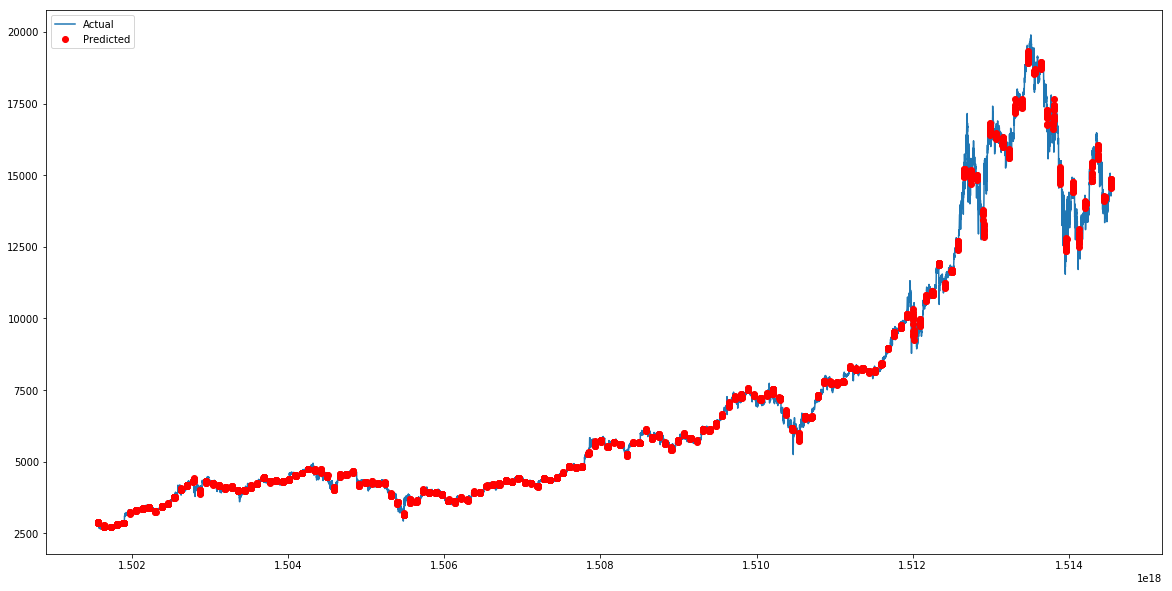

In [26]:
plt.figure(figsize=(20,10))
plt.plot(ground_true_df.times,ground_true_df.value, label = 'Actual')
# plt.plot(prediction_df.times,prediction_df.value, label = 'Predicted')
plt.plot(prediction_df.times,prediction_df.value,'ro', label='Predicted')
plt.legend(loc='upper left')
plt.savefig('result/bitcoin2015to2017_close_lr.png')
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error
mean_squared_error(validation_original_outputs[:,:,0].reshape(-1),predicted_inverted)

19789.368785630475